<a href="https://colab.research.google.com/github/AlexandreGuirado/Streamlit-DataApp-Covid-19/blob/main/Streamlit_DataApp_Covid_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install streamlit
!pip install pyngrok==4.1.1

In [ ]:
%%writefile app.py
# -*- coding: utf-8 -*-
import pandas as pd
import streamlit as st
import altair as alt #https://altair-viz.github.io/

@st.cache(allow_output_mutation=True)
def get_df(type, by="global"):
    path = f"https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_{type}_{by}.csv"
    df = pd.read_csv(path)
    return get_country_df(df, type)

def get_country_df(df, type):
    cols = ["Lat", "Long", "Province/State"]
    df = df.drop(columns=cols).rename(columns={"Country/Region": "country"})
    df["country"] = df["country"].replace({"US": "United States", "Korea, South": "South Korea"})
    df = df.melt(id_vars="country", var_name="date", value_name=f"total_{type}".lower())
    df["date"] = pd.to_datetime(df["date"])
    df = df.set_index("date").groupby("country").resample("D").sum().reset_index()
    df[f"daily_{type}"] = df.groupby("country")[f"total_{type}"].diff().fillna(0).clip(lower=0)
    return df

def days_since(df, col, num=100, groupby="country"):
    df["days_since"] = df.assign(t=df[col] >= num).groupby(groupby)["t"].cumsum()
    return df[df["days_since"] > 0]

def chart(df, y, color="country"):
    return (
        alt.Chart(df, width=750, height=500)
        .mark_line(point=True)
        .encode(
            x="days_since",
            y=alt.Y(y),
            color=color,
            tooltip=[alt.Tooltip(color), alt.Tooltip(y, format=",")],
        )
        .interactive()
    )

def main():
    by = st.radio("Escolha a análise", ["Country"])
    by = by.lower()

    if by == "country":
        confirmed_df = get_df("confirmed", "global")
        deaths_df = get_df("deaths", "global")

    else:
        confirmed_df = get_df("confirmed", "US")
        deaths_df = get_df("deaths", "US")

    chart_type = st.radio("Escolha o tipo de gráfico", ["Cumulativo", "Diario"])

    num_confirmed = st.text_input("Número de confirmados:", 100)
    confirmed_since_df = days_since(
        confirmed_df, "total_confirmed", num=int(num_confirmed), groupby=by
    )

    top_5 = (
        confirmed_since_df.groupby(by)["total_confirmed"]
        .max()
        .sort_values(ascending=False)
        .head(5)
        .index.tolist()
    )

    select_all = confirmed_since_df[by].unique().tolist()
    radio = st.radio("", ["Top 5", "Select All"])

    if radio == "Top 5":
        multi = st.multiselect("", select_all, default=top_5)
    elif radio == "Select All":
        multi = st.multiselect("", select_all, default=select_all)

    confirmed_since_df = confirmed_since_df[confirmed_since_df[by].isin(multi)]

    st.markdown(f"## Casos confirmados por dias a partir de {num_confirmed} confirmados 😷")
    if chart_type == "Cumulativo":
        st.altair_chart(chart(confirmed_since_df, "total_confirmed", color=by))
    else:
        st.altair_chart(chart(confirmed_since_df, "daily_confirmed", color=by))

    num_deaths = st.text_input("Numero de Morte(s):", 1)
    deaths_since_df = days_since(deaths_df, "total_deaths", num=int(num_deaths), groupby=by)
    deaths_since_df = deaths_since_df[deaths_since_df[by].isin(multi)]

    st.markdown(f"## Mortes por dias desde {num_deaths} morte(s)")
    if chart_type == "Cumulativo":
        st.altair_chart(chart(deaths_since_df, "total_deaths", color=by))
    else:
        st.altair_chart(chart(deaths_since_df, "daily_deaths", color=by))

    st.markdown("## Totais")
    df = (
        pd.concat(
            [
                confirmed_df.groupby(by)["total_confirmed"].max(),
                deaths_df.groupby(by)["total_deaths"].max(),
            ],
            axis=1,
        )
        .sort_values("total_deaths", ascending=False)
        .style.format("{:,}")
    )

    st.dataframe(df)

if __name__ == "__main__":
    st.title("COVID-19")
    main()

In [ ]:
!ls

**Atenção: o ideal é você acessar https://dashboard.ngrok.com/get-started/your-authtoken e criar seu authtoken gratuitamente, inserindo logo abaixo o código. Assim você não tera problemas em deploy por outras pessoas ja estarem usando o token abaixo simultaneamente.**

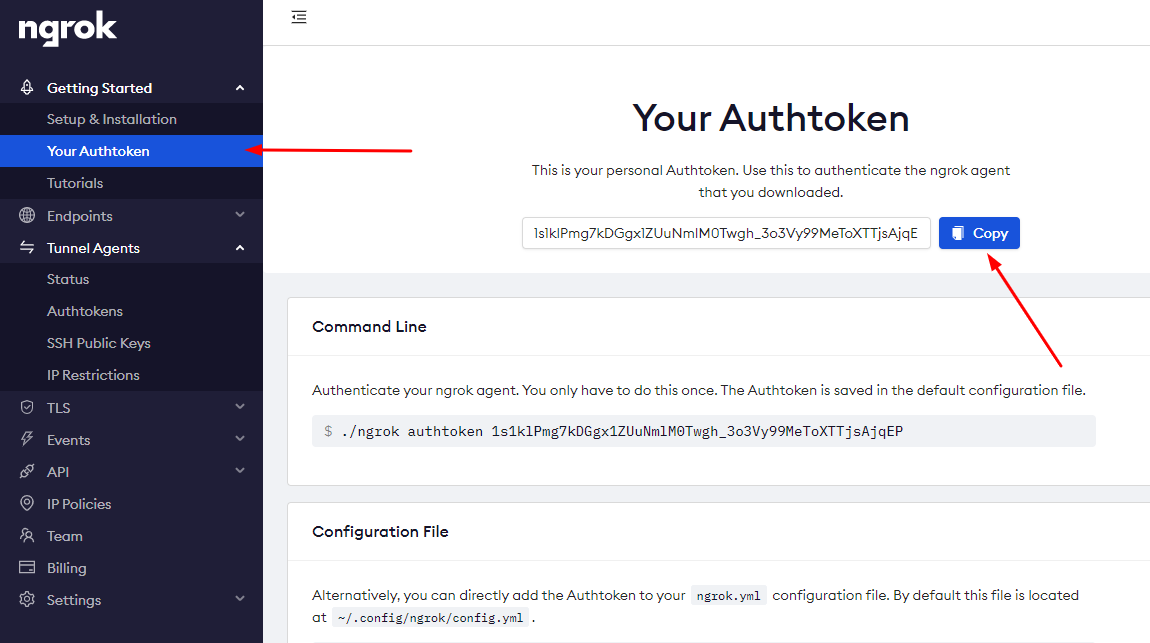

In [ ]:
#INSIRA O SEU TOKEN APÓS O AUTHTOKEN GERADO NO LINK E SEGUINDO O PASSO-A-PASSO NA IMAGEM ACIMA OU TERA PROBLEMAS DE DEPLOY
!ngrok authtoken 1s1klPmg7kDGgx1ZUuNmlM0Twgh_3o3Vy99MeToXTTjsAjqEP

In [ ]:
!streamlit run app.py &>/dev/null&

In [ ]:
!pgrep streamlit

In [ ]:
from pyngrok import ngrok
# Setando o streamlit para a porta 8501
public_url = ngrok.connect(port='8501')
public_url